<div align="center">
<img src="re-logo.png" width="230">

# A Guide: Transfer Learning On Field Boundary Datasets
</div>



In this notebook, we will:
- Set up our Colab environment.
- Load the pre-trained model.
- Explore the Kenya dataset.
- Retrain to fine-tune the model.
- Evaluate the model performance.
- Applications and future work.


## Setting up Colab

The first thing to do here is **"mounting"** your Google Drive to the Colab project.
This means we will import our Google Drive's folders and files to use on for this project.

We will be making use of the following structure:
```
field-boundary-webinar/
├── field-boundary-notebook.ipynb
├── model.h5
├── requirements.txt
├── images/
│   ├── kenol1_153.tif
│   └── kenol1_154.tif
│   └── ...
└── labels/
│   ├── kenol1_153.tif
│   └── kenol1_154.tif
│   └── ...
```

Check out https://github.com/radiantearth/Field-Boundary-Webinar/tree/main to obtain the `requirements.txt` and `model.h5` files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We have a number of different directories on Google Drive, so we will point Colab to identify the directory `field-boundary-webinar` directory and work with it.

Doing things this way also helps to organise your project better.

In [ ]:
%cd /content/drive/My Drive/field-boundary-webinar

/content/drive/My Drive/field-boundary-webinar


A `requirements.txt` file is a simple text file that lists all the external libraries and packages your Python project depends on. These are often libraries that are not included in the standard Python installation.

The libraries and packages can be installed using the `pip install` command

In [ ]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 105.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.13.1
    Uninstalling keras-2.13.1:
      Successfully uninstalled keras-2.13.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.13.0
    Uninstalling te

Note that you may need to restart the runtime for the package installation to reflect.

To ensure that they were installed correctly, run the command below. You should get `Keras` and `Tensorflow` versions as both `2.10.0`

In [ ]:
import keras
import tensorflow
print(keras.__version__)
print(tensorflow.__version__)

2.10.0
2.10.0


## Loading the Pre-Trained Model

First, we need to import the libraries needed to load the model.
The model was built using TensorFlow and `segmentation_models` library.

A [blogpost](https://medium.com/radiant-earth-insights/detecting-agricultural-croplands-from-sentinel-2-satellite-imagery-a025735d3bd8) on Medium was released to discuss the modelling details, however we will just be focusing on loading and retraining/fine-tuning the model.

We will need to also include the model's pre-defined losses and metrics using `segmentation-models` while TensorFlow will be used to load the pre-trained model and retraining it.

It is however worth noting that the model is based on semantic segmentation, where each pixel in an image is classified a corresponding class label, in this case, "field" or "no field"

In [ ]:
import segmentation_models
from skimage.io import imread

import os
os.environ["SM_FRAMEWORK"] = "tf.keras" # Fix compatibility issues

# Losses
from segmentation_models.losses import dice_loss
from segmentation_models.losses  import binary_crossentropy

# Metrics
from segmentation_models.metrics import IOUScore
from segmentation_models.metrics import FScore
from segmentation_models.metrics import Recall
from segmentation_models.metrics import Precision

from tensorflow.keras.models import load_model # For loading models

Segmentation Models: using `keras` framework.


Next, we will load the pretrained South African model.
The `model.h5` is the model file which contains the model weights and architectre.

- `model weights` refer to the parameters or coefficients that the algorithm learns during the training process. In simple terms, weights are the parameters that the model learns from your data to make predictions.

- The `model architecture` is like a blueprint that tells the model how to process information for a specific task, just like a house blueprint tells construction workers how to build a specific type of house.

- The `architecture` is the plan or blueprint that outlines how information flows through the network. The `model weights` are the specific values that make the network effective at its intended task. They're like the precise measurements that turn a blueprint into a functional house.

- `Model loss` is like a scorecard that tells the model how it's performing to adjust its "thinking".

  `Binary Cross Entropy` is effective for binary segmentation tasks, applicable is our case.

  `Dice loss` helps the model learn to create accurate boundaries around objects in images. While Dice loss originated in medical imaging, it has also found applications in other areas where precise object segmentation is crucial, such as satellite imagery and computer vision tasks.

  The model uses both losses.

- While the model doesn't "use" `metrics` in the sense of making decisions based on them, `metrics` are effective in the training process for evaluation.

The model generates a probabilistic prediction of the field boundaries from `0` to `1`, where `0` indicates no field exists at a given location and `1` indicates a field definitely exists. Thus a prediction of `0.6` means the model is `60%` confident a field exists at that location.

We chose a threshold of `0.5` to tell the model to reject `pixel values < 0.5` in its evaluation.

In [ ]:
# Load model for evaluation
threshold = 0.5 # Can edit the threshold to see the model's confidence (higher threshold evaluates how high the model is confident)
model = load_model(
    f"model.h5",
    custom_objects={
        'binary_crossentropy_plus_dice_loss':binary_crossentropy + dice_loss,
        'iou_score': IOUScore(threshold=threshold),
        'f1-score' : FScore(threshold=threshold),
        'recall': Recall(threshold=threshold),
        'precision': Precision(threshold=threshold)
    }
)

**IOU Score (Intersection over Union):**
- Think of it like a way to measure how well the model's prediction (like marking a field's boundary) matches the actual field's boundary.
- It's like asking, "How much of the predicted boundary overlaps with the real one?" The more overlap, the better.

**Precision:**
- Precision is like accuracy for positive predictions. In this case, it's about how accurate the model is when it says, "This is a field boundary!"
- High precision means the model is usually correct when it makes a positive prediction.

**Recall:**
- Recall is like completeness. It asks, "Did the model find all the field boundaries in the area?"
- High recall means the model is good at finding most of the actual field boundaries.

**F1 Score:**
- The F1 score is a way to balance precision and recall. It's like finding a sweet spot between being accurate and being thorough.
- It helps to avoid situations where a model is too cautious (high precision but low recall) or too reckless (high recall but low precision).

In [ ]:
# Load model for evaluation
threshold = 0.5 # Can edit the threshold to see the model's confidence (higher threshold evaluates how high the model is confident)
model = load_model(
    f"model_transfer_learning.h5",
    custom_objects={
        'binary_crossentropy_plus_dice_loss':binary_crossentropy + dice_loss,
        'iou_score': IOUScore(threshold=threshold),
        'f1-score' : FScore(threshold=threshold),
        'recall': Recall(threshold=threshold),
        'precision': Precision(threshold=threshold)
    }
)

## Exploring the Kenya Dataset

Next, we will load a sample image from our Kenya images and see how the model performs in extracting fields from it.

We will be using `rasterio` to handle our imagery.
Other libraries like `cv2` can be used to load imagery, but `rasterio` is more convenient to use with geospatial imagery.
Bands can be easily selected and image features extracted as seen below.

In [ ]:
import rasterio
import matplotlib.pyplot as plt
from skimage.transform import resize
import numpy as np

In [ ]:
with rasterio.open('Images/kenol1_154.tif') as src:
    # Read information about the raster
    width = src.width
    height = src.height
    count = src.count  # Number of bands
    crs = src.crs  # Coordinate Reference System
    bounds = src.bounds  # Bounding box of the raster
    meta = src.meta  # Additional metadata

    data = src.read([1, 2, 3]) # Selecting the RGB bands for the data

# Print the information
print(f"Width: {width}, Height: {height}")
print(f"Number of Bands: {count}")
print(f"Coordinate Reference System (CRS): {crs}")
print(f"Bounding Box: {bounds}")
print(f"Metadata: {meta}")

Width: 512, Height: 512
Number of Bands: 4
Coordinate Reference System (CRS): EPSG:32737
Bounding Box: BoundingBox(left=291617.57916847046, bottom=9894862.678489678, right=291662.5364430902, top=9894907.635764297)
Metadata: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 512, 'height': 512, 'count': 4, 'crs': CRS.from_epsg(32737), 'transform': Affine(0.08780717699164597, 0.0, 291617.57916847046,
       0.0, -0.08780717699119124, 9894907.635764297)}


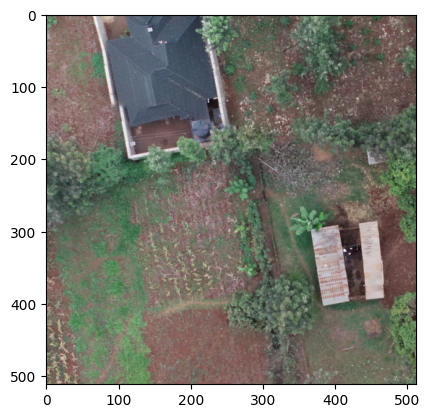

In [ ]:
plt.imshow(data.transpose(1, 2, 0))  # Transpose to (height, width, bands) for visualization

In [ ]:
data.shape

(3, 512, 512)

In [ ]:
data = data.transpose(1, 2, 0) # (3, 512, 512) -> (512, 512, 3)

In [ ]:
data.shape

(512, 512, 3)

Next, we will load the sample imagery as a `numpy` data, in the format the model accepts.

This model accepts a numpy array with dimensions `(IMAGE_NO, IMG_WIDTH, IMG_HEIGHT, BAND_NO)` where:
- `IMAGE_NO` represents the number of images contained in the array
- `IMG_WIDTH` is the image width, which is `256` for the model
- `IMG_HEIGHT` is the image height, which is also `256` for the model
- `BAND_NO` is the number of bands, which is `3`. (for RGB)

We will also resize the image from `512 x 512` to `256 x 256` for the model use case.

In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
X_test = np.zeros((1, IMG_WIDTH, IMG_HEIGHT, 3), dtype=np.uint8) # image_no is 1 since only one sample image

imge = resize(data, (256, 256), mode='constant', preserve_range=True) # Resizing 512 x 512 to 256 x 256
X_test[0] = imge #append to test image, X_test

In [ ]:
X_test.shape

(1, 256, 256, 3)

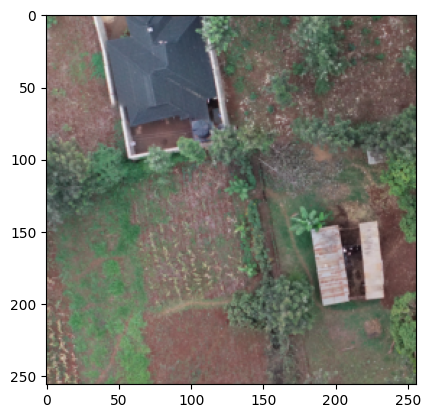

In [ ]:
plt.imshow(X_test[0])

1/1 [==============================] - 3s 3s/step


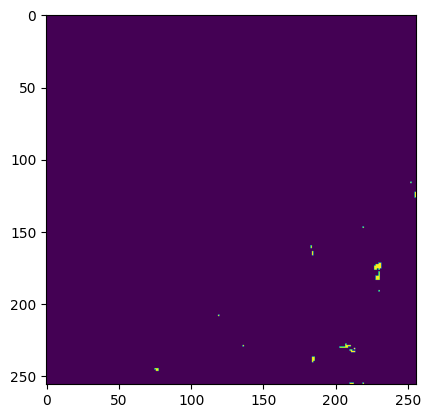

In [ ]:
# Predicting sample imagery
# X_test[:int(X_test.shape[0]) tells the model to predict all images. only one image in this case
preds_test = model.predict( X_test[:int(X_test.shape[0])], verbose=1) # verbose prints the progress report.
preds_test_t = (preds_test > threshold).astype(np.uint8) # Set threshold as mentioned earlier
plt.imshow(np.mean(preds_test_t[0], axis=2).astype('float64'))

Let's explore the labelled file now.
We'll use `rasterio` as usual to load the label file mask.

In [ ]:
with rasterio.open('Labels/kenol1_154.tif') as src:
    # Read information about the raster
    width = src.width
    height = src.height
    count = src.count  # number of bands
    crs = src.crs  # coordinate reference system
    transform = src.transform  # affine transformation
    bounds = src.bounds  # bounding box of the raster
    meta = src.meta  # additional metadata

    # Read some example data (replace [x, y] with pixel coordinates)
    x, y = 100, 100
    mask = src.read(1)


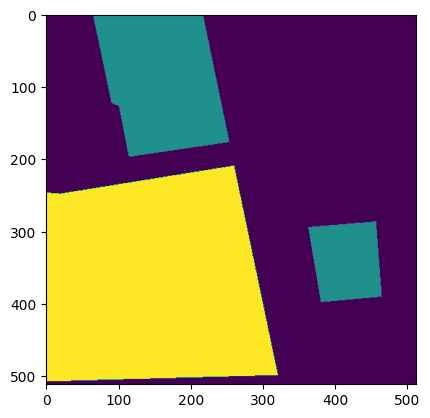

In [ ]:
# Visualising the mask
plt.imshow(mask)

As you can see, there are two different classes (`1` for building footprint and `2` for field boundary). `0` is background.

This is seen in the unique classes below using `numpy`.

In [ ]:
np.unique(mask)

array([0, 1, 2], dtype=uint8)

Since we're concerned with only fields, let's set all other cclasses to `0` (background).

In [ ]:
msk = mask
msk[(msk == 1)] = 0
msk[(msk == 2)] = 1

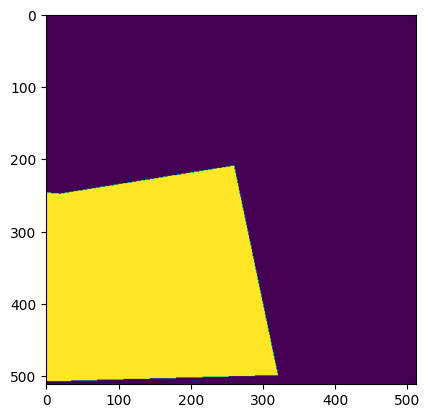

In [ ]:
plt.imshow(msk)

Next, we will load the sample label as a `numpy` data, in the format the model puts out as output.

This model's output class is a numpy array with dimensions `(IMAGE_NO, IMG_WIDTH, IMG_HEIGHT, BAND_NO)` where:
- `IMAGE_NO` represents the number of images contained in the array
- `IMG_WIDTH` is the image width, which is `256` for the model
- `IMG_HEIGHT` is the image height, which is also `256` for the model
- `BAND_NO` is the number of bands, which is `1`. (field or no field)

We will also resize the image from `512 x 512` to `256 x 256` for the model use case.

In [ ]:
y_test = np.zeros((1, 256, 256, 1), dtype=np.float32) # For test labels
sizes_test = []
sizes_test.append([msk.shape[0], msk.shape[1]])
imge = resize(msk, (256, 256, 1), mode='constant', preserve_range=True)

y_test[0] = imge #append to test label, y_test

In [ ]:
y_test[0].shape

(256, 256, 1)

## Side Note: Model Training
Although the purpose of this tutorial is transfer learning, here's a side note on the code that was used to develop the model.

Note that the requirements of the packages might be different than the onees specified on the `requirements.txt` file.

The code is not meant to be full-on reproducible but just as an extra detail to have on the model's development

In [ ]:
BATCH_SIZE = 10 # the higher the better
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
seed = 8

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import * # Load vgg for u-net backbone

######## Setting up U-Net with pre-trained VGG19 #########

# Helpful resources to understand the model: https://arxiv.org/pdf/1505.04597.pdf
# https://arxiv.org/pdf/2006.04868.pdf

def squeeze_excite_block(inputs, ratio=8): # For feature re-calibration
    # Improves performance by not losing distinguishing features
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    # he-normal takes into account the non-linearity of relu activation function and sigmoid
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def conv_block(inputs, filters):
    # Performs feature extraction
    x = inputs

    x = Conv2D(filters, (3, 3), padding="same")(x) # Produces tensor of outputs
    x = BatchNormalization()(x)# Takes conv2d output and normalises them. faster
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = squeeze_excite_block(x)

    return x

def encoder1(inputs): # vgg encoder for the unet
    skip_connections = []

    model = VGG19(include_top=False, weights='imagenet', input_tensor=inputs) # APPLYING VGG19 ENCODER
    names = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5_conv4").output
    return output, skip_connections

def decoder1(inputs, skip_connections): # u-net decoder
    num_filters = [256, 128, 64, 32]
    skip_connections.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_connections[i]])
        x = conv_block(x, f)

    return x

def encoder2(inputs):
    num_filters = [32, 64, 128, 256]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        x = conv_block(x, f)
        skip_connections.append(x)
        x = MaxPool2D((2, 2))(x)

    return x, skip_connections

def decoder2(inputs, skip_1, skip_2):
    num_filters = [256, 128, 64, 32]
    skip_2.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_1[i], skip_2[i]])
        x = conv_block(x, f)

    return x

def output_block(inputs):
    x = Conv2D(1, (1, 1), padding="same")(inputs)
    x = Activation('sigmoid')(x)
    return x

def Upsample(tensor, size):
    """Bilinear upsampling"""
    def _upsample(x, size):
        return tf.image.resize(images=x, size=size)
    return Lambda(lambda x: _upsample(x, size), output_shape=size)(tensor)

def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

def build_model(shape):
    inputs = Input(shape)
    x, skip_1 = encoder1(inputs)
    x = ASPP(x, 64)
    x = decoder1(x, skip_1)
    outputs1 = output_block(x)

    x = inputs * outputs1

    x, skip_2 = encoder2(x)
    x = ASPP(x, 64)
    x = decoder2(x, skip_1, skip_2)
    outputs2 = output_block(x)
    outputs = Concatenate()([outputs1, outputs2])

    model = Model(inputs, outputs)
    return model

In [ ]:
model = build_model((256, 256, 3)) # IMAGE SIZE
model.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                             

## Model Re-training

Let's get back to the main focus. Now, we will set the model's pre-defined metrics and losses, then compile the model. It's straightforward!

In [ ]:
metrics = [IOUScore(threshold=0.5), FScore(threshold=0.5),
           Recall(threshold=0.5), Precision(threshold=0.5)]  #applied the threshold
# loss = sm.losses.dice_loss + sm.losses.bce_jaccard_loss
model.compile(optimizer='adam', loss= binary_crossentropy+ dice_loss, metrics=metrics)
model.run_eagerly = False

We will load the rest of the images now.

Python's `os.listdir` allows us to list the files available in a directory.
We'll use the `Images` directory.

It's best practice to use this rather than the `Labels` directory as we need all images to have corresponding labels.

Next, we will split the directory list into `train` and `test` list. The `train` list will be used for model training and evaluation while the `test` list will be used for predictions and some evaluation as well.

In [ ]:
import random
image_list = os.listdir('Images')
random.shuffle(image_list)
# Calculate the partition index for an 80:20 split
partition_index = int(len(image_list) * 0.8)

# Partition into two lists
train_list = image_list[:partition_index]
test_list = image_list[partition_index:]

In [ ]:
X_train = np.zeros((len(train_list), IMG_WIDTH, IMG_HEIGHT, 3), dtype=np.uint8) # image_no is the number of images available
X_test = np.zeros((len(test_list), IMG_WIDTH, IMG_HEIGHT, 3), dtype=np.uint8) # image_no is the number of images available

i = 0
for image in train_list:
  with rasterio.open(f"Images/{image}") as src:
      data = src.read([1, 2, 3]) # Selecting the RGB bands for the data
      data = data.transpose(1, 2, 0) # (3, 512, 512) -> (512, 512, 3)
      imge = resize(data, (256, 256), mode='constant', preserve_range=True) # Resizing 512 x 512 to 256 x 256
      X_train[i] = imge #append to test image, X
  i += 1

i = 0
for image in test_list:
  with rasterio.open(f"Images/{image}") as src:
      data = src.read([1, 2, 3]) # Selecting the RGB bands for the data
      data = data.transpose(1, 2, 0) # (3, 512, 512) -> (512, 512, 3)
      imge = resize(data, (256, 256), mode='constant', preserve_range=True) # Resizing 512 x 512 to 256 x 256
      X_test[i] = imge #append to test image, X
  i += 1

In [ ]:
y_train = np.zeros((len(train_list), IMG_WIDTH, IMG_HEIGHT, 1), dtype=np.float32) # image_no is the number of images available
y_test = np.zeros((len(test_list), IMG_WIDTH, IMG_HEIGHT, 1), dtype=np.float32) # image_no is the number of images available

i = 0
for image in train_list:
  with rasterio.open(f"Labels/{image}") as src:
      mask = src.read(1)
      mask[(mask == 1)] = 0
      mask[(mask == 2)] = 1
      mask[(mask == 3)] = 0
      label = resize(mask, (256, 256, 1), mode='constant', preserve_range=True)
      y_train[i] = label #append to test image, X
  i+=1

i = 0
for image in test_list:
  with rasterio.open(f"Labels/{image}") as src:
      mask = src.read(1)
      mask[(mask == 1)] = 0
      mask[(mask == 2)] = 1
      mask[(mask == 3)] = 0 # In the case of building footprint intersection
      label = resize(mask, (256, 256, 1), mode='constant', preserve_range=True)
      y_test[i] = label # aAppend to test image, X
  i+=1

13


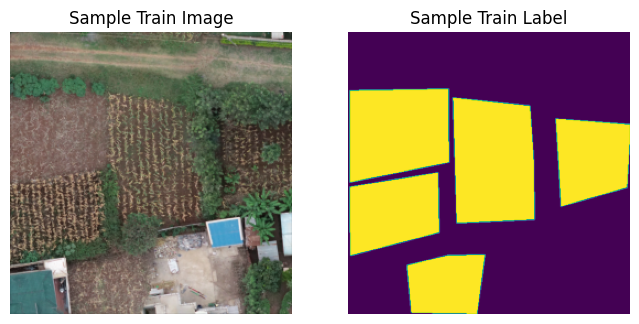

In [ ]:
# Sanity check
i = random.randint(0, len(train_list)-1)
print(i)
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 5))

# Set the titles
axs[0].set_title('Sample Train Image')
axs[1].set_title('Sample Train Label')

# Display the images
axs[0].imshow(X_train[i])
axs[1].imshow(y_train[i])
# Remove the axes for a cleaner look
for ax in axs:
    ax.axis('off')

# Show the plot
plt.show()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# tf.compat.v1.executing_eagerly_outside_functions()
# earlystopper = EarlyStopping(patience=3, verbose=1) #stopper after number of epochs to end if no improvements, did not apply initially
checkpointer = ModelCheckpoint(f"model_transfer_learning.h5", verbose=1, save_best_only=False) # TO-DO: best result as model
results =  model.fit(X_train, y_train, batch_size = 8,
                              epochs=100,callbacks=[checkpointer]) #use_multiprocessing = False

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 1.7097 - iou_score: 0.3532 - f1-score: 0.5186 - recall: 0.5836 - precision: 0.4817  
Epoch 1: saving model to model_transfer_learning.h5
6/6 [==============================] - 462s 72s/step - loss: 1.7097 - iou_score: 0.3532 - f1-score: 0.5186 - recall: 0.5836 - precision: 0.4817
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 1.0720 - iou_score: 0.5000 - f1-score: 0.6637 - recall: 0.6798 - precision: 0.6787  
Epoch 2: saving model to model_transfer_learning.h5
6/6 [==============================] - 453s 74s/step - loss: 1.0720 - iou_score: 0.5000 - f1-score: 0.6637 - recall: 0.6798 - precision: 0.6787
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 0.9080 - iou_score: 0.5654 - f1-score: 0.7214 - recall: 0.7556 - precision: 0.6994  
Epoch 3: saving model to model_transfer_learning.h5
6/6 [==============================] - 452s 75s/step - loss: 0.9080 - iou_score: 0.5654 - f1-score: 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-68884b282b40>", line 5, in <cell line: 5>
    results =  model.fit(X_train, y_train, batch_size = 8,
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/h5py/_hl/files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
  File "/usr/local/lib/python3.10/dist-packages/h5py/_hl/files.py", line 237, in make_fid
    fid = h5f.create(name, h5f.ACC_TRUNC, fapl=fapl, fcpl=fcpl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 126, in h5py.h5f.create
OSError: [E

In [ ]:
# model.save_weights("model_transfer_learning.h5")

## Model Evaluation

In [ ]:
preds_test = model.predict( X_test[:int(X_test.shape[0])], verbose=1) # Predicting the test results
preds_test_t = (preds_test > threshold).astype(np.uint8) # Setting field/no-field threshold

9
6
8
11


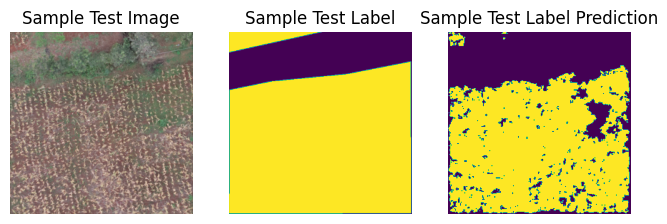

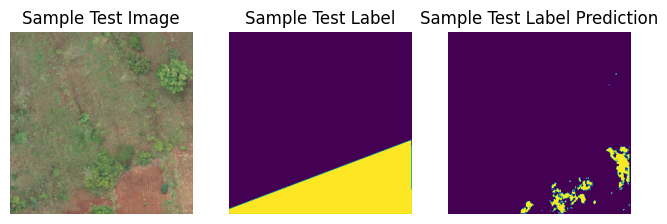

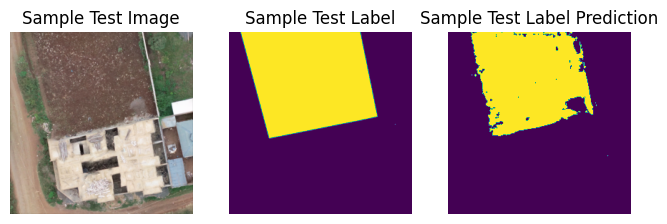

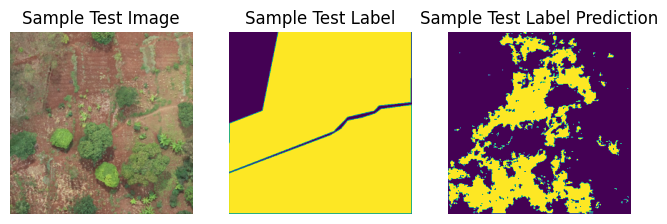

In [ ]:
# Sanity check
for j in range(4):
  i = random.randint(0, len(preds_test_t)-1)
  print(i)
  # Create a figure with two subplots
  fig, axs = plt.subplots(1, 3, figsize=(8, 5))

  # Set the titles
  axs[0].set_title('Sample Test Image')
  axs[1].set_title('Sample Test Label')
  axs[2].set_title('Sample Test Label Prediction')

  # Display the images
  axs[0].imshow(X_test[i])
  axs[1].imshow(y_test[i])
  axs[2].imshow(np.mean(preds_test_t[i], axis=2).astype('uint8'))
  # Remove the axes for a cleaner look
  for ax in axs:
      ax.axis('off')
  j+=1

In [ ]:
test_results = model.evaluate(X_test, y_test, batch_size = 8) # Evaluate the model results

2/2 [==============================] - 40s 11s/step - loss: 0.9979 - iou_score: 0.4442 - f1-score: 0.5964 - recall: 0.4581 - precision: 0.9198


## Applications and Future Work

Applications of the model include:
- **Yield Prediction:** By accurately identifying cropland, farmers can estimate potential yields, allowing for better planning and resource allocation.
- **Land use mapping:** Identifies areas suitable for urban expansion while preserving agricultural lands.
- **Satellite Imagery Analysis:** Cropland detection models are often used in conjunction with satellite imagery to monitor large-scale agricultural areas.
- **Emergency Response:** Helps identify areas affected by disasters or emergencies, facilitating targeted relief efforts.
- **Agricultural Studies:** Supports research in agricultural sciences, including studies related to land use, crop types, and farming practices.

Future Work:
- Tweaking the batch size to evaluate model's performance with more of the data.
- Saving model's results based on best performance i.e lowest loss.
- Predicting label from imagery and using the original imagery's geocordinates to map the label coordinates for analysis (vectorising it).
- Estimating cropland area using the above for field size.
- Analysing model performance (particularly f1-score) based on this field size.
- Training a fresh model for the Kenya data using the side note model training code and observing results (note that this has not been tested for sometime so take caution of errors along the way).
